## Tabular Playground Sereis - Mar 2022
---
1. Challenge
> forecast twelve-hours of traffic flow in a U.S. metropolis

2. Evaluation
> Mean Absolute Error

3. Data
> labelled with location coordinates and a direction of travel
    
* `row_id` - a unique identifier for this instance  
* `time` - the 20-minute period in which each measurement was taken  
* `x` - the east-west midpoint coordinate of the roadway  
* `y` - the north-south midpoint coordinate of the roadway  
* `direction` - the direction of travel of the roadway. EB indicates "eastbound" travel, for example, while SW indicates a "southwest" direction of travel.  
* `congestion` - congestion levels for the roadway during each hour; the target. The congestion measurements have been normalized to the range 0 to 100
---




In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from datetime import datetime
from IPython import display


In [19]:
train = pd.read_csv("./data/train.csv", index_col='row_id')
test = pd.read_csv("./data/test.csv", index_col='row_id')

In [20]:
print("train data shape :", train.shape)
print("test data shape :", test.shape)

train data shape : (848835, 5)
test data shape : (2340, 4)


In [21]:
train

,time,x,y,direction,congestion
row_id,,,,,
0,1991-04-01 00:00:00,0,0,EB,70
1,1991-04-01 00:00:00,0,0,NB,49
2,1991-04-01 00:00:00,0,0,SB,24
3,1991-04-01 00:00:00,0,1,EB,18
4,1991-04-01 00:00:00,0,1,NB,60
...,...,...,...,...,...
848830,1991-09-30 11:40:00,2,3,NB,54
848831,1991-09-30 11:40:00,2,3,NE,28
848832,1991-09-30 11:40:00,2,3,SB,68


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 848835 entries, 0 to 848834
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time        848835 non-null  object
 1   x           848835 non-null  int64 
 2   y           848835 non-null  int64 
 3   direction   848835 non-null  object
 4   congestion  848835 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 38.9+ MB


In [23]:
print(train.x.unique())
print(train.y.unique())
print(train.direction.unique())

[0 1 2]
[0 1 2 3]
['EB' 'NB' 'SB' 'WB' 'NE' 'SW' 'NW' 'SE']


In [24]:
train.groupby(['x', 'y', 'direction']).time.count()

x  y  direction
0  0  EB           13059
      NB           13059
      SB           13059
   1  EB           13059
      NB           13059
                   ...  
2  3  NB           13059
      NE           13059
      SB           13059
      SW           13059
      WB           13059
Name: time, Length: 65, dtype: int64

In [25]:
train[train.time.str.contains("1991-04-01") == True]

,time,x,y,direction,congestion
row_id,,,,,
0,1991-04-01 00:00:00,0,0,EB,70
1,1991-04-01 00:00:00,0,0,NB,49
2,1991-04-01 00:00:00,0,0,SB,24
3,1991-04-01 00:00:00,0,1,EB,18
4,1991-04-01 00:00:00,0,1,NB,60
...,...,...,...,...,...
4675,1991-04-01 23:40:00,2,3,NB,67
4676,1991-04-01 23:40:00,2,3,NE,25
4677,1991-04-01 23:40:00,2,3,SB,64


In [26]:
def get_date(x):
    return x.split()[0]

In [27]:
train['date'] = train['time'].apply(get_date)
test['date'] = test['time'].apply(get_date)

In [28]:
def get_year(x):
    return int(x.split('-')[0])

def get_month(x):
    return int(x.split('-')[1])

def get_date(x):
    return int(x.split('-')[2])

In [29]:
train['year'] = train['date'].apply(get_year)
train['month'] = train['date'].apply(get_month)
train['date'] = train['date'].apply(get_date)

test['year'] = test['date'].apply(get_year)
test['month'] = test['date'].apply(get_month)
test['date'] = test['date'].apply(get_date)

In [32]:
def extract_time(x):
    return x.split()[1]

train['time'] = train['time'].apply(extract_time)
test['time'] = test['time'].apply(extract_time)

In [34]:
def get_hour(x):
    return int(x.split(':')[0])

def get_minute(x):
    return int(x.split(':')[1])

train['hour'] = train['time'].apply(get_hour)
train['minute'] = train['time'].apply(get_minute)

test['hour'] = test['time'].apply(get_hour)
test['minute'] = test['time'].apply(get_minute)

In [35]:
train

,time,x,y,direction,congestion,date,year,month,hour,minute
row_id,,,,,,,,,,
0,00:00:00,0,0,EB,70,1,1991,4,0,0
1,00:00:00,0,0,NB,49,1,1991,4,0,0
2,00:00:00,0,0,SB,24,1,1991,4,0,0
3,00:00:00,0,1,EB,18,1,1991,4,0,0
4,00:00:00,0,1,NB,60,1,1991,4,0,0
...,...,...,...,...,...,...,...,...,...,...
848830,11:40:00,2,3,NB,54,30,1991,9,11,40
848831,11:40:00,2,3,NE,28,30,1991,9,11,40
848832,11:40:00,2,3,SB,68,30,1991,9,11,40


In [36]:
train.drop('time', axis=1, inplace=True)
test.drop('time', axis=1, inplace=True)

train

,x,y,direction,congestion,date,year,month,hour,minute
row_id,,,,,,,,,
0,0,0,EB,70,1,1991,4,0,0
1,0,0,NB,49,1,1991,4,0,0
2,0,0,SB,24,1,1991,4,0,0
3,0,1,EB,18,1,1991,4,0,0
4,0,1,NB,60,1,1991,4,0,0
...,...,...,...,...,...,...,...,...,...
848830,2,3,NB,54,30,1991,9,11,40
848831,2,3,NE,28,30,1991,9,11,40
848832,2,3,SB,68,30,1991,9,11,40


In [39]:
def weeknd_or_nah(year,month,date):
    if datetime(year,month,date).weekday() > 4:
        return 0 
    else:
        return 1

train['weekday'] = train.apply(lambda x:weeknd_or_nah(x['year'], x['month'], x['date']), axis=1)
test['weekday'] = test.apply(lambda x:weeknd_or_nah(x['year'], x['month'], x['date']), axis=1)

In [41]:
def get_day(year,month,date):
    return (calendar.day_name[datetime(year,month,date).weekday()])

train['day'] = train.apply(lambda x:get_day(x['year'],x['month'],x['date']),axis=1)
test['day'] = test.apply(lambda x:get_day(x['year'],x['month'],x['date']),axis=1)

In [44]:
def am_or_pm(x):
    if x>=12:
        return 1
    else:
        return 0

train['PM'] = train['hour'].apply(am_or_pm)
test['PM'] = test['hour'].apply(am_or_pm)

In [45]:
train

,x,y,direction,congestion,date,year,month,hour,minute,weekday,day,PM
row_id,,,,,,,,,,,,
0,0,0,EB,70,1,1991,4,0,0,1,Monday,0
1,0,0,NB,49,1,1991,4,0,0,1,Monday,0
2,0,0,SB,24,1,1991,4,0,0,1,Monday,0
3,0,1,EB,18,1,1991,4,0,0,1,Monday,0
4,0,1,NB,60,1,1991,4,0,0,1,Monday,0
...,...,...,...,...,...,...,...,...,...,...,...,...
848830,2,3,NB,54,30,1991,9,11,40,1,Monday,0
848831,2,3,NE,28,30,1991,9,11,40,1,Monday,0
848832,2,3,SB,68,30,1991,9,11,40,1,Monday,0


In [49]:
train.drop(['year', 'month', 'date'], axis=1, inplace=True)
test.drop(['year', 'month', 'date'], axis=1, inplace=True)

In [50]:
X = train.drop('congestion', axis=1)
y = train['congestion']

In [53]:
X['x'], X['y'] = X['x'].astype(str), X['y'].astype(str)
test['x'], test['y'] = test['x'].astype(str), test['y'].astype(str)

X['hour'] = X['hour']/23
X['minute'] = X['minute']/59

test['hour'] = test['hour']/23
test['minute'] = test['minute']/59

In [56]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X['direction'] = le.fit_transform(X['direction'])
test['direction'] = le.fit_transform(test['direction'])
X['day'] = le.fit_transform(X['day'])
test['day'] = le.fit_transform(test['day'])

In [58]:
pd.get_dummies(X).columns.difference(pd.get_dummies(test).columns)

Index([], dtype='object')

In [59]:
X = pd.get_dummies(X)
test = pd.get_dummies(test)

In [60]:
X.shape, test.shape

((848835, 13), (2340, 13))

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
X

,direction,hour,minute,weekday,day,PM,x_0,x_1,x_2,y_0,y_1,y_2,y_3
row_id,,,,,,,,,,,,,
0,0,0.000000,0.000000,1,1,0,1,0,0,1,0,0,0
1,1,0.000000,0.000000,1,1,0,1,0,0,1,0,0,0
2,4,0.000000,0.000000,1,1,0,1,0,0,1,0,0,0
3,0,0.000000,0.000000,1,1,0,1,0,0,0,1,0,0
4,1,0.000000,0.000000,1,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
848830,1,0.478261,0.677966,1,1,0,0,0,1,0,0,0,1
848831,2,0.478261,0.677966,1,1,0,0,0,1,0,0,0,1
848832,4,0.478261,0.677966,1,1,0,0,0,1,0,0,0,1


In [38]:
print(train.direction.unique())

['EB' 'NB' 'SB' 'WB' 'NE' 'SW' 'NW' 'SE']


In [39]:
xy_dir = {'EB': (1,0), 'WB': (-1,0), 'SB': (0, -1), 'NB': (0, 1),
          'NE': (1, 1), 'SE': (-1, 1), 'NW': (1, -1), 'SW': (-1, -1)}

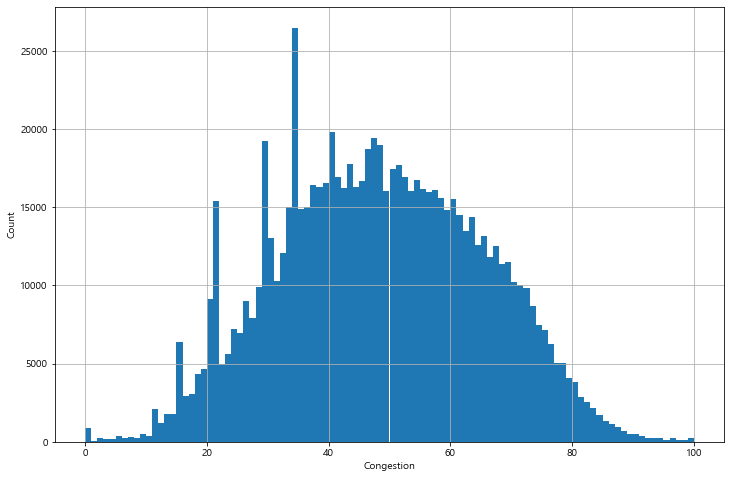

In [40]:
plt.figure(figsize=(12, 8))
train.congestion.hist(bins=100)
plt.xlabel('Congestion')
plt.ylabel('Count')
plt.show()

In [41]:
mean = train['congestion'].mean()
std = train['congestion'].std()

<AxesSubplot:xlabel='time', ylabel='congestion'>

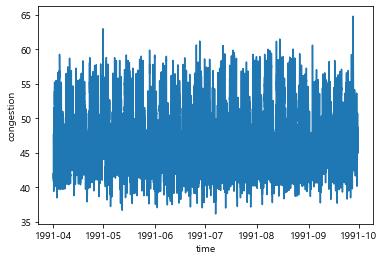

In [43]:
ts = train.groupby('time').agg({'congestion' : 'mean'})
sns.lineplot(data=ts, x='time', y='congestion')